In [188]:
import numpy as np
import pandas as pd
import random

from pyprojroot import here
import seaborn as sns
from matplotlib import pyplot as plt
from mlxtend.plotting import heatmap
from mlxtend.plotting import plot_decision_regions

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers


import keras_tuner as kt
from keras_tuner import HyperParameters


from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils import shuffle

import wandb
from wandb.integration.keras import WandbMetricsLogger
from wandb.integration.keras import WandbModelCheckpoint


random.seed(7)

In [165]:
X_train = pd.read_csv(here('data/processed/X_train_scaled.csv'))
print(X_train.shape)
y_train = pd.read_csv(here('data/processed/Y_train.csv'))
print(y_train.shape)


X_val = pd.read_csv(here('data/processed/X_val_scaled.csv'))
print(X_val.shape)
y_val = pd.read_csv(here('data/processed/Y_val.csv'))
print(y_val.shape)

(7499, 6)
(7499, 6)
(1501, 6)
(1501, 6)


Machine failure
0    1451
1      50
Name: count, dtype: int64


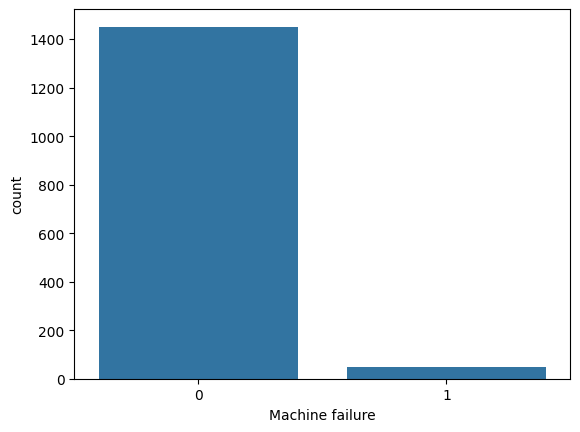

In [166]:
sns.barplot(y_val['Machine failure'].value_counts())
print(y_val['Machine failure'].value_counts())

In [167]:
#Setting interested failure mode
y_train_machine_failure = y_train['Machine failure']
y_val_machine_failure = y_val['Machine failure']

In [189]:

# Split the training data by class
X_majority = X_train[y_train_machine_failure == 0]
X_minority = X_train[y_train_machine_failure == 1]

# Downsample majority class to match the size of the minority class
X_majority_downsampled, y_majority_downsampled = resample(X_majority, 
                                                           y_train_machine_failure[y_train_machine_failure == 0],
                                                           replace=False,  # no replacement
                                                           n_samples=len(X_minority),  # downsample to the minority count
                                                           random_state=7)

# Combine the downsampled majority class with the minority class
X_train_balanced = np.vstack((X_majority_downsampled, X_minority))
y_train_balanced = np.hstack((y_majority_downsampled, y_train_machine_failure[y_train_machine_failure == 1]))

# Shuffle the balanced training set

X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=7)


In [190]:
def build_model(num_features):
    """Return a simple logistic regression model using the Keras Sequential API."""
  # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(7)
    

  # Use Keras Sequential API to build a logistic regression
    model = keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),
         name='Input'
    ))
   
    
    model.add(keras.layers.Dense(
        units=1,  
        use_bias=True,
        activation='sigmoid',
        #kernel_initializer='random_normal',
        #bias_initializer='zeros',
        kernel_initializer=initializers.RandomNormal(stddev=0.01),
        bias_initializer=initializers.RandomNormal(stddev=0.01),
        name="Output"
    ))
  
  # Use Binary Crossentropy as our loss and the SGD optimizer.
    model.compile(
        loss= tf.keras.losses.BinaryCrossentropy(),
        optimizer= tf.keras.optimizers.SGD(learning_rate=0.01),
        metrics= [tf.keras.metrics.BinaryAccuracy()]
    )
    return model

# Build a model
model = build_model(num_features=X_train.shape[1])


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Output (Dense)                  │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7 (28.00 B)

 Trainable params: 7 (28.00 B)

 Non-trainable params: 0 (0.00 B)

In [169]:
X_train.shape, y_train_machine_failure.shape

((7499, 6), (7499,))

In [170]:
tf.random.set_seed(7)
np.random.seed(7)

hist= model.fit(x= X_train,
                y= y_train_machine_failure,
                validation_data= [X_val,y_val_machine_failure],
                
                batch_size=len(X_train),
               
                epochs=20,
                verbose=1 
)

Epoch 1/20


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - binary_accuracy: 0.0327 - loss: 8.3458 - val_binary_accuracy: 0.9667 - val_loss: 106.5486
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - binary_accuracy: 0.9673 - loss: 104.5057 - val_binary_accuracy: 0.9667 - val_loss: 102.9390
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - binary_accuracy: 0.9673 - loss: 100.9653 - val_binary_accuracy: 0.9667 - val_loss: 99.3294
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.9673 - loss: 97.4249 - val_binary_accuracy: 0.9667 - val_loss: 95.7198
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.9673 - loss: 93.8845 - val_binary_accuracy: 0.9667 - val_loss: 92.1102
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.9673 - loss: 90.3441 - val_binary_accuracy: 0.9667 - val_loss: 88.5006
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.9673 - loss: 86.8037 - val_binary_accuracy: 0.9667 - val_loss: 84.8909
Epoch 8/20
1/1 ━━━━━

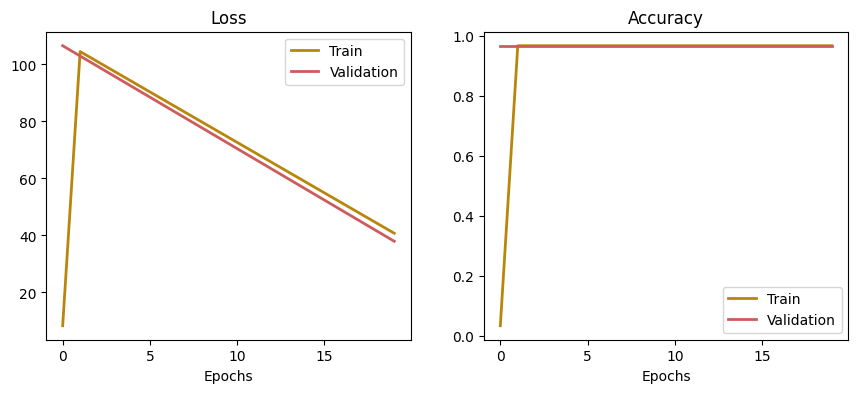

In [173]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_binary_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');


In [175]:
tf.random.set_seed(7)

# YOUR CODE HERE

class build_model_tuner(kt.HyperModel):
    def build(self, hp):
        lr = hp.Choice("learning_rate", [.1, .01, .001, .02])
        model = build_model(num_features=X_train.shape[1])

        model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
        )
        return model

    def fit(self, hp, model, x, y, **kwargs):
        epochs = hp.Choice("epochs", [100, 200, 300, 400])
        return model.fit(x, y, epochs=epochs,
                         validation_data=(X_val, y_val_machine_failure),
                         **kwargs)


tuner = kt.BayesianOptimization(
    build_model_tuner(),
    objective=kt.Objective("val_loss", "min"),
    max_trials=50,
    num_initial_points=20,
    seed=7,
    directory=".",
    project_name="teamproject"
)

tuner.search(X_train, y_train_machine_failure)
#1.Learned Model Params + Bias
best_model = tuner.get_best_models(1)[0]
print(best_model)
kernel, bias = best_model.layers[0].get_weights()
print(f" kernel is {kernel}")
print(f"bias is {bias}")

#2. Loss at the final epoch of training and validation sets
best_trial = tuner.oracle.get_best_trials(1)[0]
final_train_evolution = best_trial.metrics.get_history("loss")[-1].value[-1]
final_val_evolution = best_trial.metrics.get_history("val_loss")[-1].value[-1]
print(f"final train loss is {final_train_evolution}, final val loss is {final_val_evolution}")

# Difference of the last epoch loss training and val
print(final_train_evolution - final_val_evolution)
print('======='*20)
#Personal look best params
print(best_trial.display_hyperparameters())
best_hp = tuner.get_best_hyperparameters(1)[0]
lr = best_hp['learning_rate']
epochs = best_hp['epochs']

Trial 16 Complete [00h 00m 45s]
val_loss: 0.12219572812318802

Best val_loss So Far: 0.12219572812318802
Total elapsed time: 00h 07m 26s
<Sequential name=sequential, built=True>
 kernel is [[-0.19850713]
 [ 0.90631545]
 [ 0.32124367]
 [-0.01998969]
 [ 1.8108208 ]
 [ 1.0940855 ]]
bias is [-0.00755899]
final train loss is 4.107700347900391, final val loss is 0.12219572812318802
3.9855046197772026
learning_rate: 0.001
epochs: 400
None


In [193]:

class build_model_tuner(kt.HyperModel):
    def build(self, hp):
        lr = hp.Choice("learning_rate", [.001,.0001])
        model = build_model(num_features=X_train.shape[1])  
        model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
        )
        return model

    def fit(self, hp, model, x, y, **kwargs):
        # one W&B run per trial, log hyperparams + metrics
        run = wandb.init(
            project="predictive-maintenance",
            name=f"bayes-trial-{wandb.util.generate_id()}",
            config=hp.values,
            reinit=True
        )
        try:
            epochs = hp.Choice("epochs", [100, 200, 300, 400,500])
            return model.fit(
                x, y,
                epochs=epochs,
                validation_data=(X_val, y_val_machine_failure),
                callbacks=[WandbMetricsLogger()],
)
        finally:
            wandb.finish()


In [194]:
tuner = kt.BayesianOptimization(
    build_model_tuner(),
    objective=kt.Objective("val_loss", "min"),
    max_trials=50,
    num_initial_points=20,
    seed=7,
    directory=".",
    project_name="predictive-maintenance"
)

tuner.search(X_train, y_train_machine_failure)


Trial 10 Complete [00h 00m 46s]
val_loss: 0.159734845161438

Best val_loss So Far: 0.11567715555429459
Total elapsed time: 00h 05m 49s
